# Introduction

As is known to all, body fat percentage is an important measure of obesity and plays an important role in various health outcomes. However, usually it is difficult and complicated to calculate since the information needed like underwater weighing is not applicable in practice. In this project, we are aiming to derive an accurate and precise "rule-of-thumb" method to estimate percentage of body fat with few clinically available measurements. From the provided dataset, which is consisting of bodyfat calculated by siri equation and many body measures among 252 males, we found that weight and abdomen are strongly correlated with bodyfat. We built, diagnosed and tested the model in the statistical analysis below. The model established achieves high performance over the provided dataset.

# Statistical Analysis

## 1. Load Data and Packages

In [1]:
## assume working directory is the one that current juno is in
remove(list = ls())
set.seed(1)
dt.path = "Data/BodyFat.csv"
dt.fat = read.csv(dt.path)
body.fat = subset(dt.fat, select = c(-IDNO, -DENSITY))

In [2]:
suppressMessages(if(!require("dplyr")){install.packages("dplyr")})
suppressMessages(if(!require("tidyverse")){install.packages("tidyverse")})
suppressMessages(if(!require("caret")){install.packages("caret")})
suppressMessages(if(!require("car")){install.packages("car")})

## 2. Data Description

The dataset consists of bady fat calculated from siri's equation, density from underwater weighing, age, weight, height, BMI, neck circumference, chest circumference, abcomen circumference, hip circumference, thigh circumference, knee circumference, ankle circumference, biceps circumference, forearm circumference and wrist circumference. To have an intuitive view of the data set, we first draw histgrams for some features.

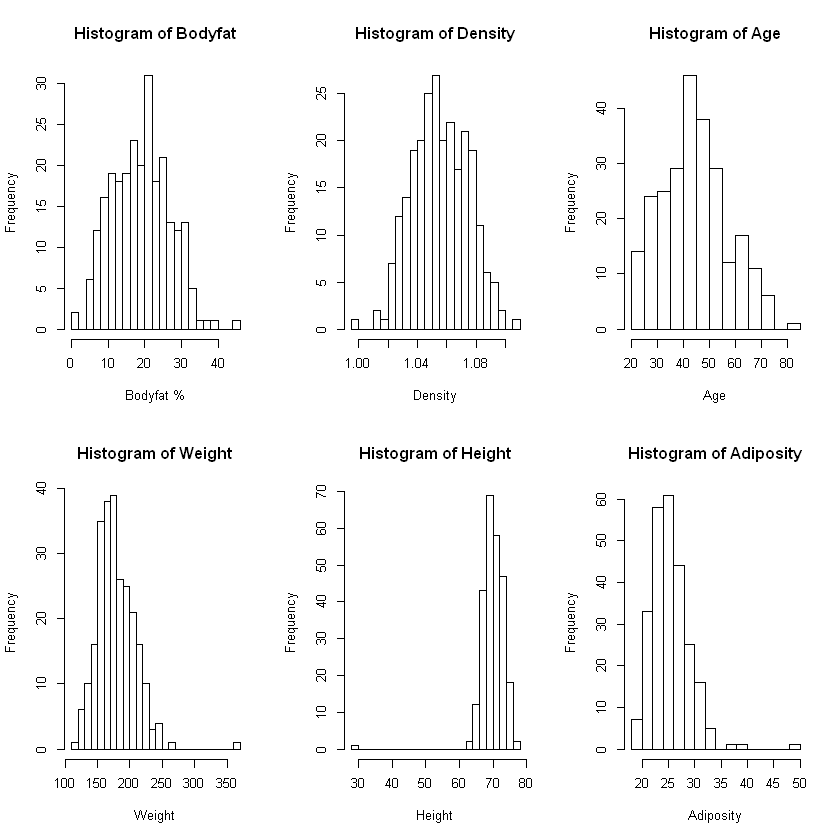

In [4]:
par(mfrow=c(2,3))
hist(dt.fat$BODYFAT,breaks = 20, 
     main = "Histogram of Bodyfat",xlab="Bodyfat %")
hist(dt.fat$DENSITY,breaks = 20, 
     main = "Histogram of Density",xlab="Density")
hist(dt.fat$AGE,breaks = 20, 
     main = "Histogram of Age",xlab="Age")
hist(dt.fat$WEIGHT,breaks = 20, 
     main = "Histogram of Weight",xlab="Weight")
hist(dt.fat$HEIGHT,breaks = 20, 
     main = "Histogram of Height",xlab="Height")
hist(dt.fat$ADIPOSITY,breaks = 20, 
     main = "Histogram of Adiposity",xlab="Adiposity")

We note that there might be some outliers for each feature so we deal with the data cleaning in the next part.

## 3. Data Cleaning

Given Siri's equation, we know that
$$B = \frac{495}{D} - 450\ ,\ where$$
* B = proportion of fat tissue * 100 = BODYFAT
* D = Body Density = DENSITY

We plot body fat against $\frac{1}{Density}$ and there are some points lie out of the line. The individuals whose bodyfats are not equal to the bodyfat computed by density may be wrong records. Thus we compute the bodyfat using siri's equation and density to locate those outliers and look into them for imputation or deletion.

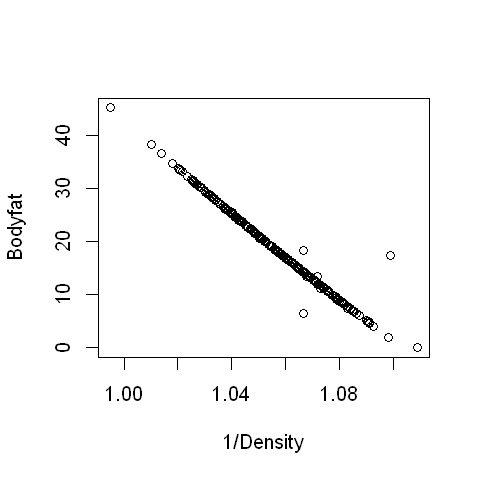

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
plot(dt.fat$BODYFAT ~ 1/dt.fat$DENSITY,xlab = "1/Density",ylab = "Bodyfat")
id<-as.vector(dt.fat$IDNO)
bodyf<-as.vector(dt.fat$BODYFAT)
den<-as.vector(dt.fat$DENSITY)
diff<-abs(bodyf -(495/den-450))
ab<-cbind(id,diff)
#ab[order(ab[,2],decreasing = T),][1:10,]

In [7]:
col.mean1 = round(sapply(cbind(495/den-450,dt.fat[,-1]), dim = 1, FUN = mean), digits = 2)
bd = rbind(cbind(495/den[c(182,96, 48,54, 76,124)]-450,dt.fat[c(182,96, 48,54, 76,124), -1]), col.mean1)
colnames(bd)[1] = "BODYFAT_computed"
rownames(bd)[4] = '54 (compared with 48)'
rownames(bd)[6] = '124 (compared with 76)'
rownames(bd)[7] = ' Sample Mean'
bd

BODYFAT_computed BODYFAT DENSITY AGE   WEIGHT HEIGHT
182                    -3.6116873        0.00   1.1089  40.00 118.50 68.00 
96                      0.3684833       17.30   1.0991  53.00 224.50 77.75 
48                     14.1350211        6.40   1.0665  39.00 148.50 71.25 
54 (compared with 48)   6.3053097        7.10   1.0848  49.00 152.75 73.50 
76                     14.0915057       18.30   1.0666  61.00 148.25 67.50 
124 (compared with 76) 15.9700650       16.00   1.0623  47.00 151.50 66.75 
 Sample Mean           19.0900000       18.94   1.0600  44.88 178.92 70.15 
                       ADIPOSITY NECK  CHEST  ABDOMEN HIP   THIGH KNEE  ANKLE
182                    18.10     33.80  79.30 69.40    85.0 47.20 33.50 20.2 
96                     26.10     41.10 113.20 99.20   107.5 61.70 42.30 23.2 
48                     20.60     34.60  89.80 79.50    92.7 52.70 37.50 21.9 
54 (compared with 48)  19.90     35.10  93.30 79.60    91.6 52.60 37.60 22.6 
76                     22.90     36.00  91.60 81.80    94.8 54.50 37.00 21.4 
124 (compared with 76) 23.90     36.90  94.00 86.10    95.2 58.10 36.50 22.1 
 Sample Mean           25.44     37.99 100.82 92.56    99.9 59.41 38.59 23.1 
                       BICEPS FOREARM WRIST
182                    27.70  24.60   16.50
96                     32.90  30.80   20.40
48                     28.80  26.80   17.90
54 (compared with 48)  38.50  27.40   18.50
76                     29.30  27.00   18.30
124 (compared with 76) 30.60  27.50   17.60
 Sample Mean           32.27  28.66   18.23

**For No.182:**
No one's bodyfat can be 0 or negative. Therefore we should delete this abnormal point(No.182).

**For No.96:**
The bodyfat computed by the density is 495/1.0991-450=0.3684833. It is very close to 0. Therefore we think the density is wrong meanwhile the bodyfat is right. So we will keep this point.

**For No.48:**
We find a normal point(No.54) which is very similar with No.48 point except AGE and BICEPS. But these two factors influence bodyfat little. Therefore we think the bodyfat of No.48 point is normal. Then we keep this point.

**For No.76:**
We find a normal point(No.124) which is very similar with No.76 point .Therefore we think the bodyfat of No.76 point is normal. Then we keep this point.

From the histgram of height in the previous part, we notice that there is a person whose height is around 30 inches. But when we look into this point, we find that his weight and BMI are quite normal, so we take the height as a wrong record and use $ADIPOSITY = \frac{WEIGHT}{HIGHT^2} $ to impute it.
Using this formula, we also find No.163 and No.221 as two possible bad points candidates.
Similarly, we also look into the outliers in other features.

In [8]:
# Impute the height for the shortest man
body.fat$HEIGHT[42] = round(sqrt(205*0.45359237/29.9)*39.3700787,1)
# The person with largest bodyfat
dt.fat[dt.fat$BODYFAT==max(dt.fat$BODYFAT), ]
body.fat.clean <- body.fat[-c(182,216,221),]

IDNO BODYFAT DENSITY AGE WEIGHT HEIGHT ADIPOSITY NECK CHEST ABDOMEN HIP  
216 216  45.1    0.995   51  219    64     37.6      41.2 119.8 122.1   112.8
    THIGH KNEE ANKLE BICEPS FOREARM WRIST
216 62.5  36.9 23.6  34.7   29.1    18.4

The one with bodyfat 45.1% is too impossible  to exist in the world and his density is smaller than 1. So we delete this example.

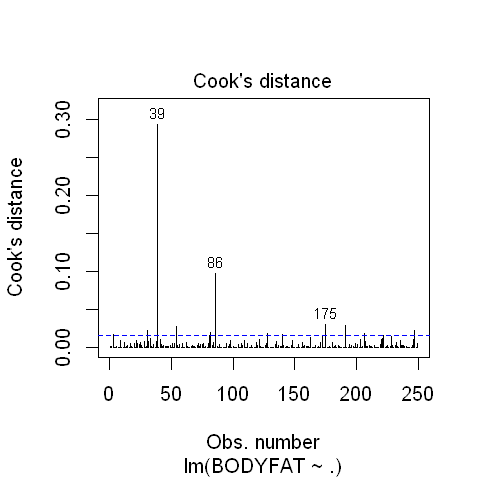

In [9]:
model.clean = lm(BODYFAT ~ ., data = body.fat.clean)
# summary(model.clean)$coefficient
plot(model.clean, which = 4)
abline(h = 4/(dim(body.fat)[1]-dim(body.fat)[2]), lty = 2, col = 'blue')

In [10]:
col.mean = round(sapply(body.fat, dim = 1, FUN = mean), digits = 2)
. = rbind(body.fat[c(39, 86), ], col.mean)
rownames(.)[3] = ' Sample Mean'
.

BODYFAT AGE   WEIGHT HEIGHT ADIPOSITY NECK  CHEST  ABDOMEN HIP  
39           33.80   46.00 363.15 72.25  48.90     51.20 136.20 148.10  147.7
86           25.80   67.00 167.00 67.50  26.00     36.50  98.90  89.70   96.2
 Sample Mean 18.94   44.88 178.92 70.31  25.44     37.99 100.82  92.56   99.9
             THIGH KNEE  ANKLE BICEPS FOREARM WRIST
39           87.30 49.10 29.6  45.00  29.00   21.40
86           54.70 37.80 33.7  32.40  27.70   18.20
 Sample Mean 59.41 38.59 23.1  32.27  28.66   18.23

* Sample 39 is highly overweighted.However, \#39 is merely a stronger person whose body measurements are within normal range. 
* Sample 86 has relatively larger Cook's distance. However, \#86 is merely a person whose body measurements are within normal range. 

Therefore, \#39, \#86 and \#221 should be kept in our model.

**Given the above, $163, 182, 216, 221$ show up as outlier candidates.**

In [11]:
body.fat.clean = body.fat[-c(163, 182,216,221),]

## 3. Variable Selection

### Linear Model

We decided to use AIC, BIC as the criterions to determine the best linear model.

#### Stepwise selection using AIC

In [13]:
model.full = lm(BODYFAT ~ ., data = body.fat.clean)
model.1 <- lm(BODYFAT~1,data = body.fat.clean)
model.AIC.forward <- step(model.1,list(lower = model.1,upper = model.full),k = 2,direction = "forward",trace = 0)
model.AIC.backward <- step(model.full,k = 2,direction = "backward",trace = 0)
model.AIC.both = step(model.full, direction = "both", k = 2, trace = 0)
cat("AIC in forward direction:\n")
cat("Variables selected =", names(model.AIC.forward$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.AIC.forward)$adj.r.squared,"AIC =", AIC(model.AIC.forward,k = 2))
cat("\nAIC in backward direction:\n")
cat("Variables selected =", names(model.AIC.backward$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.AIC.backward)$adj.r.squared,"AIC =", AIC(model.AIC.backward,k = 2))
cat("\nAIC in both direction:\n")
cat("Variables selected =", names(model.AIC.both$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.AIC.both)$adj.r.squared,"AIC =", AIC(model.AIC.both,k = 2))

AIC in forward direction:
Variables selected = ABDOMEN WEIGHT WRIST FOREARM THIGH AGE NECK HIP
Adjusted R square = 0.7276523 AIC = 1392.721
AIC in backward direction:
Variables selected = AGE WEIGHT HEIGHT ADIPOSITY NECK ABDOMEN HIP THIGH FOREARM WRIST
Adjusted R square = 0.7284305 AIC = 1393.928
AIC in both direction:
Variables selected = AGE WEIGHT HEIGHT ADIPOSITY NECK ABDOMEN HIP THIGH FOREARM WRIST
Adjusted R square = 0.7284305 AIC = 1393.928

#### Stepwise selection using BIC

In [14]:
model.BIC.forward <- step(model.1,list(lower = model.1,upper = model.full),k = log(dim(body.fat.clean)[1]),direction = "forward",trace = 0)
model.BIC.backward <- step(model.full,k = log(dim(body.fat.clean)[1]),direction = "backward",trace = 0)
model.BIC.both = step(model.full, direction = "both", k = log(dim(body.fat.clean)[1]), trace = 0)
cat("BIC in forward direction:\n")
cat("Variables selected =", names(model.BIC.forward$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.BIC.forward)$adj.r.squared,"BIC =", BIC(model.BIC.forward))
cat("\nBIC in backward direction:\n")
cat("Variables selected =", names(model.BIC.backward$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.BIC.backward)$adj.r.squared,"BIC =", BIC(model.BIC.backward))
cat("\nBIC in both direction:\n")
cat("Variables selected =", names(model.BIC.both$coefficients)[-1])
cat("\nAdjusted R square =",summary(model.BIC.both)$adj.r.squared,"BIC =", BIC(model.BIC.both))

BIC in forward direction:
Variables selected = ABDOMEN WEIGHT WRIST FOREARM
Adjusted R square = 0.7192771 BIC = 1417.43
BIC in backward direction:
Variables selected = WEIGHT ABDOMEN FOREARM WRIST
Adjusted R square = 0.7192771 BIC = 1417.43
BIC in both direction:
Variables selected = WEIGHT ABDOMEN FOREARM WRIST
Adjusted R square = 0.7192771 BIC = 1417.43

The models selected by AIC and BIC achieve 0.7 Rsquare and contain at least 4 features, which is not satisfying in performance and convenience. We get the similar result by the Mallow's Cp and R-square. Then we are looking for different model by looking into the Siri's equation.

### Fraction Model

From the Siri's equation, we know that there is a linear relationship between Bodyfat and $\frac{1}{Density}$, and $\frac{1}{Density} = \frac{Volume}{Weight}$. We consider that the model taking the form as $\text{Bodyfat }= \beta_1 \frac{X_1}{\text{Weight}} + \beta_2 \frac{1}{\text{Weight}} + \beta_3$ may have better performance.

First we manipulate the data by deviding all features by weight.

In [15]:
data = body.fat.clean
data.invwei <- data.frame(BODYFAT = data$BODYFAT,HEIGHT = data$HEIGHT/data$WEIGHT,
                          ADIPOSITY = data$ADIPOSITY/data$WEIGHT,NECK = data$NECK/data$WEIGHT,
                          CHEST = data$CHEST/data$WEIGHT,ABDOMEN = data$ABDOMEN/data$WEIGHT,
                          HIP = data$HIP/data$WEIGHT,THIGH = data$THIGH/data$WEIGHT,
                          KNEE = data$KNEE/data$WEIGHT,ANKLE = data$ANKLE/data$WEIGHT,
                          BICEPS = data$BICEPS/data$WEIGHT,FOREARM = data$FOREARM/data$WEIGHT,
                          WRIST = data$WRIST/data$WEIGHT)
data.invwei$inv_wei <- 1/data$WEIGHT

Since we are going to derive a rule-of-thumb method, we tried all other features in turn to select the one with the highest Rsquare and smallest RMSE.

In [16]:
BF.nonlinear = body.fat.clean
kFoldCV = 10

nonWeightCol = c(2, seq(4, 15))
WeightCol = c(3)

BF.nonlinear[, nonWeightCol] = BF.nonlinear[, nonWeightCol] / BF.nonlinear[, WeightCol]
BF.nonlinear$invWeight = 1 / BF.nonlinear$WEIGHT
BF.nonlinear$WEIGHT = NULL

fracModelsInfo = data.frame(matrix(ncol = 3, nrow = length(nonWeightCol)))
colnames(fracModelsInfo) = c("Variable.Name", "RMSE", "rSquare")

set.seed(123) 
train.control = trainControl(method = "cv", number = kFoldCV)

for(i in seq(2, 14)){
    varName = colnames(BF.nonlinear)[i]
    model = train(BODYFAT ~ . , data = BF.nonlinear[, c("BODYFAT", "invWeight", varName)],
                  method = "lm", trControl = train.control)
    
    fracModelsInfo$Variable.Name[i-1] = varName
    fracModelsInfo$RMSE[i-1] = model$results[, 'RMSE']
    fracModelsInfo$rSquare[i-1] = model$results[, 'Rsquared']
    # fracModelsInfo$model[i-1] = model$finalModel
}

In [17]:
cat("Best Model by RMSE")
fracModelsInfo[ which.min(fracModelsInfo$RMSE),  ]
cat("Best Model by R Square")
fracModelsInfo[ which.max(fracModelsInfo$rSquare),  ]

fracModelBestVar = fracModelsInfo[ which.min(fracModelsInfo$RMSE), 'Variable.Name']

# cat("Sorted by RMSE")
# fracModelsInfo[ order(fracModelsInfo$RMSE), ]
# cat("Sorted by R Square")
# fracModelsInfo[ order(fracModelsInfo$rSquare, decreasing = TRUE), ]

Best Model by RMSE

Variable.Name RMSE     rSquare  
6 ABDOMEN       4.042052 0.7162784

Best Model by R Square

Variable.Name RMSE     rSquare  
6 ABDOMEN       4.042052 0.7162784

The model consist of abdomen and weight achieves 0.7097 rSquare in 10-fold cross-validation, which has the best performance among all the features.

In [18]:
frac.model.1 = lm(BODYFAT ~ . , data = BF.nonlinear[, c("BODYFAT", "invWeight", fracModelBestVar)])
summary(frac.model.1)$coefficients # >>> the intercept is not significant so we consider drop it in the next model. 

Estimate      Std. Error t value     Pr(>|t|)    
(Intercept)     -2.515201   3.558925  -0.7067305 4.804056e-01
invWeight   -10736.297074 438.877197 -24.4631007 1.027335e-67
ABDOMEN        158.986218   9.565547  16.6207139 4.765775e-42

From the summary above, the intercept is not significant so we regress a model without the intercept. The final model is shown below.

In [19]:
frac.model.2 = lm(BODYFAT ~ . -1, data = BF.nonlinear[, c("BODYFAT", "invWeight", fracModelBestVar)])
summary(frac.model.2)$coef
cat("r.adjusted.square =",summary(frac.model.2)$adj.r.square)
cat("\nAIC =",AIC(frac.model.2))
cat("\nBIC =",BIC(frac.model.2))

Estimate    Std. Error t value   Pr(>|t|)    
invWeight -10632.6530 413.228708 -25.73067 1.024413e-71
ABDOMEN      153.0505   4.573421  33.46521 1.501279e-93

r.adjusted.square = 0.9604932
AIC = 1401.851
BIC = 1412.392

This fraction model achieves high adjusted R square and its BIC is even lower than the 4 variables linear model we selected before.

## 4. Multicolinearity in the linear model

From the above study, we can get two simple models. If we consider the simple linear model, we get a model with four variables in the end: 

\begin{equation}
\text{BODYFAT} = \text{WEIGHT} + \text{ABDOMEN} + \text{FOREARM} + \text{WRIST}
\end{equation}

Next, we are going to detect multicolinearity problem among the four variables.

In [20]:
training.index = sample(1:dim(body.fat.clean)[1],size = 0.7*dim(body.fat.clean)[1])
training.set = body.fat.clean[training.index,]
test.set = body.fat.clean[-training.index,]

In [21]:
# Full model with four variables
m1 = lm(BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST, data = training.set)
predictions = predict(m1,test.set)
df1 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))
vif(m1)

WEIGHT  ABDOMEN  FOREARM    WRIST 
7.295306 4.936668 1.777062 2.560136

From the full model, **weight** has the highest VIF value and it may have some multicolinearity problem. In order to find two variables that has the best prediction power while suffer less from multicoliearity problem, we are going to drop the variables gradually to see whether the model performance changes a lot.

In [22]:
# Drop WEIGHT >>> model performance does not change too much so we can dropping weight might be helpful with multicolinearity
m2 = lm(BODYFAT ~ ABDOMEN + FOREARM + WRIST, data = training.set)
predictions = predict(m2,test.set)
df2 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + ABDOMEN >>> model performance gets worse so we can not drop ABDOMEN
m3 = lm(BODYFAT ~ FOREARM + WRIST, data = training.set)
predictions = predict(m3,test.set)
df3 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + FOREARM
m4 = lm(BODYFAT ~ ABDOMEN + WRIST, data = training.set)
predictions = predict(m4,test.set)
df4 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WEIGHT + WRIST
m5 = lm(BODYFAT ~ ABDOMEN + FOREARM, data = training.set)
predictions = predict(m5,test.set)
df5 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

# Drop WRIST + FOREARM
m6 = lm(BODYFAT ~ WEIGHT + ABDOMEN, data = training.set)
predictions = predict(m6,test.set)
df6 = data.frame(RMSE = RMSE(predictions, test.set$BODYFAT),
                 R2 = R2(predictions, test.set$BODYFAT))

In [23]:
result= data.frame(c("Full model", "ABDOMEN + FOREARM + WRIST", "FOREARM + WRIST",
                            "ABDOMEN + WRIST", "ABDOMEN + FOREARM","WEIGHT + ABDOMEN"))
df = rbind(df1, df2, df3, df4, df5, df6)
result = cbind(result, df)
colnames(result) = c("Models", "RMSE", "R2")
result

Models                    RMSE     R2       
1 Full model                3.932999 0.7312308
2 ABDOMEN + FOREARM + WRIST 4.098147 0.7046941
3 FOREARM + WRIST           7.150815 0.1227004
4 ABDOMEN + WRIST           4.044140 0.7120020
5 ABDOMEN + FOREARM         4.216864 0.6900930
6 WEIGHT + ABDOMEN          3.907055 0.7311774

From the above table, we can conclude that
\begin{equation}
BODYFAT = ABDOMEN + WRIST
\end{equation}
is the best linear models.

In [36]:
linear.model = lm(BODYFAT~ABDOMEN+WRIST,data = body.fat.clean)
summary(linear.model)$coef
cat("r.adjusted.square =",summary(linear.model)$adj.r.square)
cat("\nAIC =",AIC(linear.model))
cat("\nBIC =",BIC(linear.model))

Estimate   Std. Error t value   Pr(>|t|)    
(Intercept) -7.2559452 5.43110887 -1.335997 1.827899e-01
ABDOMEN      0.6815091 0.03255384 20.934830 1.729292e-56
WRIST       -2.0216956 0.37162380 -5.440167 1.288420e-07

r.adjusted.square = 0.6831847
AIC = 1424.378
BIC = 1438.431

## 4. Compare the linear model and fraction model

Now we have two models. The linear model:
\begin{equation}
\text{Bodyfat} = 0.682 \times \text{Abdomen} -2.022 \times \text{Wrist}-7.256, R^2 = 0.6832
\end{equation}
The fraction model:
\begin{equation}
\text{Bodyfat }= 153.0505\times \frac{\text{Abdomen}}{\text{Weight}} - 10632.6530 \times \frac{1}{\text{Weight}}, R^2 = 0.9604
\end{equation}

From the adjusted R square, AIC and BIC, we can see that the fraction model is significantly better than the linear model with the same number of variables. We choose the fraction model as the final model.

## 5. Dignostics

Taking $\frac{\text{Abdomen}}{\text{Weight}}$ and $\frac{1}{\text{Weight}}$ as two variables, we are going to check the linearity, homoskedastic, normality and additive assumptions for linear regression.

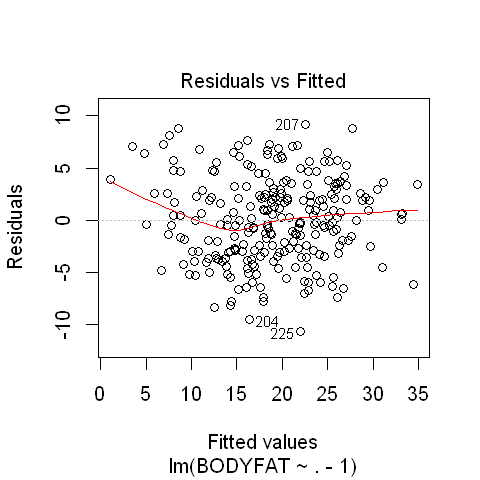

In [25]:
plot(frac.model.2,which = 1)

The standardized residuals are symmetrically distributed around 0 and there is no obvious heteriscedasticity pattern. We conclude that the linearity and homoskedastic assumptions hold.
To check the normality, we look at the QQ plot.

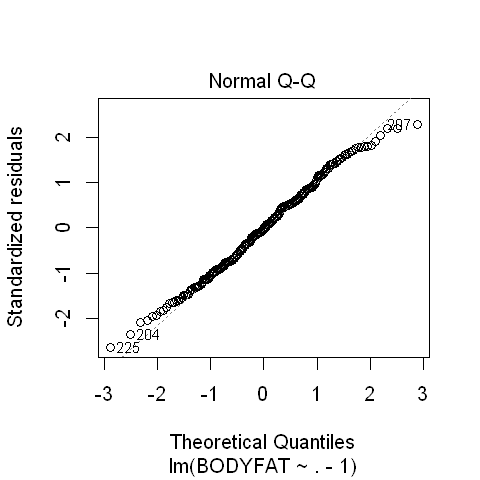

In [26]:
plot(frac.model.2,which = 2)

The normality assupmtion also holds.

# Conclusion

Our proposed model to predict bodyfat is 
\begin{equation}
\text{Bodyfat }= 153 \times \frac{\text{Abdomen}}{\text{Weight}} - 1.06 \times 10^4 \times \frac{1}{\text{Weight}}, R^2 = 0.9604
\end{equation}

**Rule of thumb**ï¼š$153$ times the ratio between abdomen and weight, and then minus $1.06*10^4$ times the inverse of weight.

**Example**: if a person has a weight of $184.5$lbs and his abdomen circumstance is $86.4$inches. Then his body fat is $153 \times \frac{86.4}{184.5} - \frac{1.06\times 10^4}{184.5}=13.75\%$.


**Strengths and weakness of model**:

Strength:
1. Our model only relates to two clinically available measurement, so it is convenient for practical use.
2. Good performance: reaching 0.96 R square indicates good estimation

Weakness:
1. Overfitting: The R square over full data is much larger than the R square calculated by cross validation, which indicates a trend of overfitting. 
2. Since we decided to choose Weight as the denominator, we only have one variable Abdomen on the numerator to estimate the volume of an individual. This may cause the inaccurate estimation of volume.

# Contributions of each member

Every group member put a lot of efforts into this project and our contributions are:
* Chao Chang: Linear model variable selection with BIC/AIC in both direction; Build the shiny App.
* Yezhou Li: Fraction model variable selection with cross validation; Report summary.
* Shuyang Chen: Linear model variable selection with backward/ forward BIC/AIC; Organize code, figure and data file.
* Ping Yu: Linear model variable selection with Mallow's Cp and $R^2$; Report summary; Presentation slides.
